In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')

In [3]:

# Merge embeddings with the main dataset (df) based on advertiser name
df = df.merge(df_advertiser, on="advertiser_name", how="left")

In [4]:
# Define the indices to drop
rows_to_remove = [69130, 69131, 69132, 69133, 69134, 69135]

# Drop the rows
df = df.drop(index=rows_to_remove, errors='ignore')

In [5]:
df_keywords = df_keywords.drop(index=rows_to_remove, errors='ignore')

In [6]:
print(df)

       no_of_days  ext_service_id  creative_id  template_id  advertiser_id  \
0        0.059322             128         1000         90.0           4756   
1        0.067797              16         1000         90.0           4756   
2        0.076271             128         1000         90.0           4756   
3        0.084746             128         1000         90.0           4756   
4        0.093220               4         1000         90.0           4756   
...           ...             ...          ...          ...            ...   
69195    0.016949             128        13710         90.0           5857   
69196    0.025424             128        13710         90.0           5857   
69197    0.033898             128        13710         90.0           5857   
69198    0.042373             128        13710         90.0           5857   
69199    0.050847              16        13710         90.0           5857   

      advertiser_name  network_id  channel_id  campaign_budget_

In [7]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df[['campaign_index','no_of_days']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df[['plateform_DV360', 'plateform_Facebook Ads', 'plateform_Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df[['channel_Display', 'channel_Mobile', 
                   'channel_Search', 'channel_Social', 'channel_Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


creative_data = df[['creative_id', 'creative_dimension']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


template_data = df[['template_id']]
# Convert to tensor format
template_features = torch.tensor(template_data.values, dtype=torch.float)
# data['template'] is the template node feature storage
data['template'].x = template_features


keyword_data = df_keywords[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


network_data = df[['network_id']]
# Convert to tensor format
network_features = torch.tensor(network_data.values, dtype=torch.float)
# data['network'] is the network node feature storage
data['network'].x = network_features


advertiser_id = df[['advertiser_id']].values  # (69,000, 1)
advertiser_data = df[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(np.hstack((advertiser_id, advertiser_data)), dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features

In [8]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)


data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)


# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# # Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)


data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)




# The corresponding click values for each record
click_values = torch.tensor(df['clicks'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Ensure shapes are appropriate
print(f"clicks shape: {click_values.shape}")

clicks shape: torch.Size([69194])


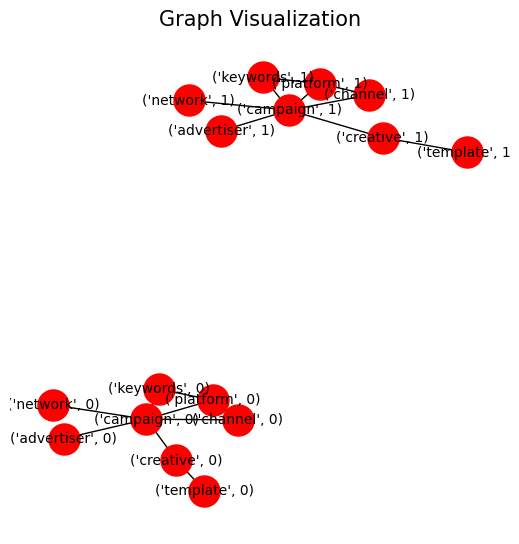

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [10]:
from torch_geometric.utils import is_undirected, contains_self_loops
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define HeteroConv layer with SAGEConv for each relation
        self.conv1 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv3 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        # 🔹 Add LayerNorm for stability
        self.norm1 = torch.nn.LayerNorm(hidden_dim)
        self.norm2 = torch.nn.LayerNorm(hidden_dim)
        self.norm3 = torch.nn.LayerNorm(hidden_dim)

        # Fully connected layer to produce a single output (click value)
        self.fc = torch.nn.Linear(hidden_dim * 8, 1)  # Concatenating features from 6 node types

        

    def forward(self, x_dict, edge_index_dict):

        # 🔹 Apply first convolution
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: self.norm1(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        # 🔹 Apply second convolution
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: self.norm2(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        # 🔹 Apply third convolution
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: self.norm3(x) for key, x in x_dict.items()}  # 🔹 Normalize
        
        # Concatenate the features of campaign, platform, and channel for each record
        x_combined = torch.cat([x_dict['campaign'], x_dict['platform'],
                                x_dict['channel'], x_dict['creative'],
                                 x_dict['template'], x_dict['keywords'], 
                                x_dict['network'], x_dict['advertiser']], dim=1)
        
        # Pass through the fully connected layer to get the single click prediction
        out = self.fc(x_combined)
        
        return out


In [11]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Get indices for campaigns (assuming 'campaign' nodes are being predicted)
campaign_indices = torch.arange(data.x_dict['campaign'].size(0))

# 80% Train, 20% Test Split
train_idx, test_idx = train_test_split(campaign_indices.cpu().numpy(), test_size=0.2, random_state=42)

# Convert to tensors
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=device)

In [12]:
from sklearn.preprocessing import StandardScaler


# Initialize model
model = HeteroGCN(hidden_dim=32)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR by 50% every 50 epochs

scaler = StandardScaler()
for key in data.x_dict.keys():
    data.x_dict[key] = torch.tensor(scaler.fit_transform(data.x_dict[key].cpu().numpy()), dtype=torch.float32).to(device)

click_values = (click_values - click_values.min()) / (click_values.max() - click_values.min())


num_epochs = 80
best_mse = float('inf')
patience = 50
counter = 0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data (only train nodes)
    out = model(data.x_dict, data.edge_index_dict)
    train_loss = F.mse_loss(out.squeeze()[train_idx], click_values[train_idx])

    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # 🔹 Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_out = model(data.x_dict, data.edge_index_dict)  # No need for a separate test_data
        test_loss = F.mse_loss(test_out.squeeze()[test_idx], click_values[test_idx])

    test_losses.append(test_loss.item())

    print(f"Epoch {epoch}, Train MSE: {train_loss.item():.4f}, Test MSE: {test_loss.item():.4f}")


HeteroGCN(
  (conv1): HeteroConv(num_relations=11)
  (conv2): HeteroConv(num_relations=11)
  (conv3): HeteroConv(num_relations=11)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Epoch 0, Train MSE: 0.0532, Test MSE: 0.3593
Epoch 1, Train MSE: 0.3649, Test MSE: 0.0231
Epoch 2, Train MSE: 0.0236, Test MSE: 0.1895
Epoch 3, Train MSE: 0.1862, Test MSE: 0.2192
Epoch 4, Train MSE: 0.2159, Test MSE: 0.0837
Epoch 5, Train MSE: 0.0821, Test MSE: 0.0084
Epoch 6, Train MSE: 0.0085, Test MSE: 0.0526
Epoch 7, Train MSE: 0.0538, Test MSE: 0.1087
Epoch 8, Train MSE: 0.1101, Test MSE: 0.0924
Epoch 9, Train MSE: 0.0935, Test MSE: 0.0351
Epoch 10, Train MSE: 0.0357, Test MSE: 0.0024
Epoch 11, Train MSE: 0.0025, Test MSE: 0.0179
Epoch 12, Train MSE: 0.0177, Test MSE: 0.0499
Epoch 13, Train MSE: 0.0496,

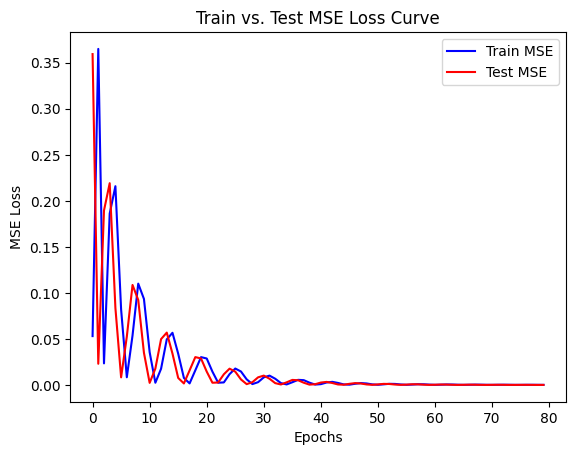

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label="Train MSE", color='blue')
plt.plot(range(len(test_losses)), test_losses, label="Test MSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Train vs. Test MSE Loss Curve")
plt.show()


In [14]:
import torch.nn.functional as F

def evaluate_model(model, data, click_values, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Move data to the correct device
        data = data.to(device)
        click_values = click_values.to(device)
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        # Ensure shapes match
        out = out.view(-1)  # Flatten predictions if necessary
        click_values = click_values.view(-1)  # Flatten actual values if necessary
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out, click_values)  
        return mse.item()
    
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
mse_score = evaluate_model(model, data, click_values, device)
print(f"Test MSE: {mse_score:.4f}")


Test MSE: 0.0002


In [15]:
def r_squared(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    
    return 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero

# Unscale predictions before calculating R²
predictions = model(data.x_dict, data.edge_index_dict).squeeze()
predictions = predictions * click_values.max()  # Reverse Min-Max Scaling

# Compute R²
r2_score = r_squared(click_values, predictions)
print(f"Test R²: {r2_score:.4f}")


Test R²: -2.4181


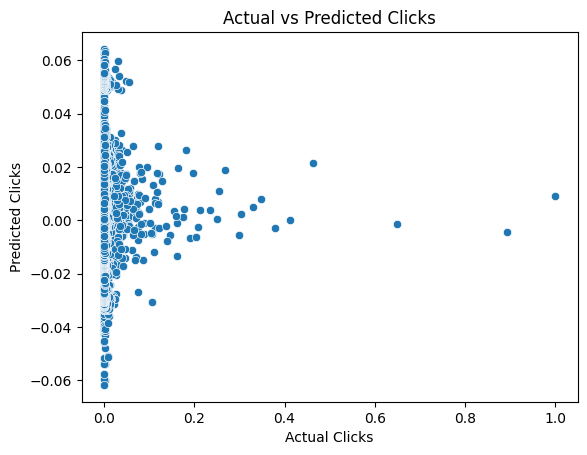

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=click_values.cpu().numpy(), y=predictions.cpu().detach().numpy())
plt.xlabel("Actual Clicks")
plt.ylabel("Predicted Clicks")
plt.title("Actual vs Predicted Clicks")
plt.show()


In [17]:
model.eval()
with torch.no_grad():
    predictions = model(data.x_dict, data.edge_index_dict).squeeze()[test_idx]

print("Actual vs Predicted Clicks:")
for actual, predicted in zip(click_values[test_idx][:10].tolist(), predictions[:10].tolist()):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")


Actual vs Predicted Clicks:
Actual: 0.0012, Predicted: 0.0039
Actual: 0.0002, Predicted: -0.0102
Actual: 0.0001, Predicted: 0.0212
Actual: 0.0000, Predicted: 0.0233
Actual: 0.0002, Predicted: 0.0107
Actual: 0.0001, Predicted: -0.0168
Actual: 0.0000, Predicted: 0.0216
Actual: 0.0001, Predicted: 0.0112
Actual: 0.0001, Predicted: 0.0059
Actual: 0.0003, Predicted: -0.0069


In [46]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

# Assuming your model is defined as 'model'
# and you've already prepared the new graph (with updated node features and edges)

# New data for prediction (single data point)
new_campaign = torch.tensor([[1000, 3]], dtype=torch.float)  # Single new campaign feature (1 new campaign)

new_platform = torch.tensor([[0, 1, 0]], dtype=torch.float)  # Single new platform feature (1 new platform)

new_channel = torch.tensor([[0, 0, 0, 0, 1]], dtype=torch.float)  # Single new channel feature (1 new channel)

new_creative = torch.tensor([[1600, 0]], dtype=torch.float)  # Single new creative feature (1 new creative)

new_template = torch.tensor([[91]], dtype=torch.float)  # Single new template feature (1 new template)

new_network = torch.tensor([[190]], dtype=torch.float)  # Single new network feature (1 new network)

new_keywords = torch.rand((1, 50), dtype=torch.float)  # Single new keywords feature (1 new keywords)

new_advertiser = torch.rand((1, 51), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)

# Add the new nodes and their features to the graph
data['campaign'].x = torch.cat([data['campaign'].x, new_campaign], dim=0)
data['platform'].x = torch.cat([data['platform'].x, new_platform], dim=0)
data['channel'].x = torch.cat([data['channel'].x, new_channel], dim=0)
data['creative'].x = torch.cat([data['creative'].x, new_creative], dim=0)
data['template'].x = torch.cat([data['template'].x, new_template], dim=0)
data['network'].x = torch.cat([data['network'].x, new_network], dim=0)
data['keywords'].x = torch.cat([data['keywords'].x, new_keywords], dim=0)
data['advertiser'].x = torch.cat([data['advertiser'].x, new_advertiser], dim=0)

new_campaign_index = data['campaign'].x.size(0) - 1
new_platform_index = data['platform'].x.size(0) - 1
new_channel_index = data['channel'].x.size(0) - 1
new_creative_index = data['creative'].x.size(0) - 1
new_template_index = data['template'].x.size(0) - 1
new_network_index = data['network'].x.size(0) - 1
new_keywords_index = data['keywords'].x.size(0) - 1
new_advertiser_index = data['advertiser'].x.size(0) - 1

# # Prepare new edges if necessary (e.g., new connections between the new campaign and existing platforms, etc.)
# # Example: adding edges for the new campaign (connect to existing platforms)
# new_campaign_index = torch.tensor([data['campaign'].x.size(0) - 1])  # Index for the new campaign
# new_platform_index = torch.tensor([0])  # Platform index to connect the new campaign to

data['campaign', 'hosted_on', 'platform'].edge_index = torch.cat(
    [data['campaign', 'hosted_on', 'platform'].edge_index,
     torch.tensor([[new_campaign_index], [new_platform_index]], dtype=torch.long)], dim=1
)

data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.cat(
    [data['platform', 'rev_hosted_on', 'campaign'].edge_index,
     torch.tensor([[new_platform_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['campaign', 'uses', 'channel'].edge_index = torch.cat(
    [data['campaign', 'uses', 'channel'].edge_index,
     torch.tensor([[new_campaign_index], [new_channel_index]], dtype=torch.long)], dim=1
)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.cat(
    [data['channel', 'rev_uses', 'campaign'].edge_index,
     torch.tensor([[new_channel_index], [new_campaign_index]], dtype=torch.long)], dim=1
)

data['platform', 'supports', 'channel'].edge_index = torch.cat(
    [data['platform', 'supports', 'channel'].edge_index,
     torch.tensor([[new_platform_index], [new_channel_index]], dtype=torch.long)], dim=1
)


data['campaign', 'uses', 'creative'].edge_index = torch.cat(
    [data['campaign', 'uses', 'creative'].edge_index,
     torch.tensor([[new_campaign_index], [new_creative_index]], dtype=torch.long)], dim=1
)

data['creative', 'designed_with', 'template'].edge_index = torch.cat(
    [data['creative', 'designed_with', 'template'].edge_index,
     torch.tensor([[new_creative_index], [new_template_index]], dtype=torch.long)], dim=1
)

data['campaign', 'associated_with', 'keywords'].edge_index = torch.cat(
    [data['campaign', 'associated_with', 'keywords'].edge_index,
     torch.tensor([[new_campaign_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'managed_by', 'network'].edge_index = torch.cat(
    [data['campaign', 'managed_by', 'network'].edge_index,
     torch.tensor([[new_campaign_index], [new_network_index]], dtype=torch.long)], dim=1
)

data['platform', 'optimized_for', 'keywords'].edge_index = torch.cat(
    [data['platform', 'optimized_for', 'keywords'].edge_index,
     torch.tensor([[new_platform_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

data['campaign', 'belongs_to', 'advertiser'].edge_index = torch.cat(
    [data['campaign', 'belongs_to', 'advertiser'].edge_index,
     torch.tensor([[new_campaign_index], [new_advertiser_index]], dtype=torch.long)], dim=1
)



In [47]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)

new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())


Predicted clicks for new campaign: -0.25626468658447266


In [48]:
torch.save(model.state_dict(), "sage_model.pth")  # ✅ Save only weights
